# Asset Allocation and Risk Budgeting using CPPI Strategies

Portfolio risk management using diligent asset allocation strategy to limit downside risk   
*by Chee-Foong on 24 Nov 2020*  

---

## Summary
This is an interactive notebook to study and analyse the CPPI strategies with drawdown constraits.  This enhancement allows for the floor to be dynamically adjusted upwards based on its last peak, creating more downside protection.

## Importing Libraries

In [4]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

import sys  
sys.path.append('../src') 
from edge_risk_kit import *

import edge_risk_kit as erk

In [5]:
import ipywidgets as widgets
from IPython.display import display

In [6]:
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

DATA_FOLDER = '../data/'

## Risky Asset

- Download S&P 500 prices which will be used as a risky asset

In [172]:
tickers = ['^GSPC']

start_date = '1900-01-01'
end_date = '2020-12-31'

In [173]:
import yfinance as yf

tickerlist = {}
for ticker in tickers:
    tickerlist[ticker] = yf.Ticker(ticker).info['shortName']
    
data = yf.download(tickers, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [174]:
prices = data[['Adj Close']].dropna()
prices.columns = ['SnP']

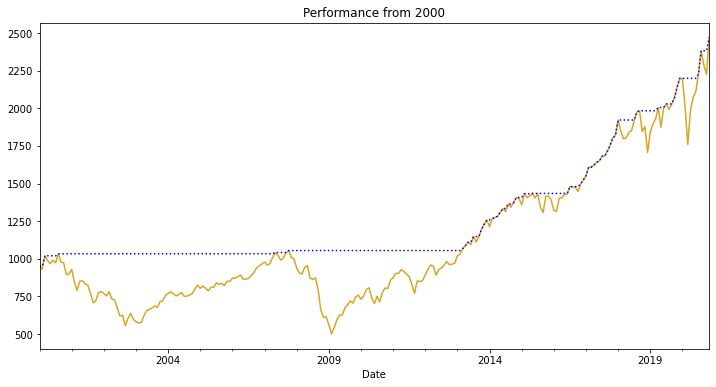

In [176]:
px_monthly = prices.resample('M').fillna('ffill')
px_monthly.index = px_monthly.index.to_period('M')
rets_monthly = px_monthly.pct_change().dropna()
risky_r = rets_monthly.SnP['2000':]

dd_risky = erk.drawdown(risky_r)
ax = dd_risky["Wealth"].plot(figsize=(12,6), ls='-', color='goldenrod')
dd_risky['Previous Peak'].plot(ax=ax, ls=':', color='blue')
ax.set_title('Performance from 2000')
plt.show()

## Safe Asset

- Assume safe deposit at risk-free interest rate

In [182]:
cashrate = 0.02
monthly_cashreturn = (1+cashrate)**(1/12)-1

## Backtesting - Market vs CPPI Portfolio

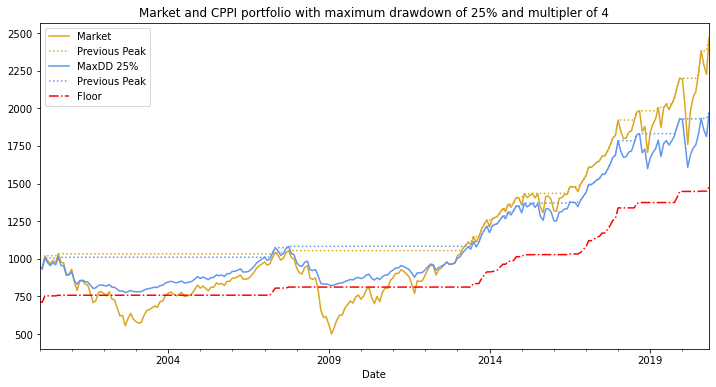

In [184]:
maxdd = 0.25
m = 4

rets_cash = pd.DataFrame(data=monthly_cashreturn, index=risky_r.index, columns=[0])
rets_risky = pd.DataFrame(data=risky_r.values, index=risky_r.index, columns=[0])
rets_maxdd25 = erk.bt_mix(rets_risky, rets_cash, allocator=erk.drawdown_allocator, maxdd=maxdd, m=m)

dd_25 = erk.drawdown(rets_maxdd25[0])

ax = dd_risky['Wealth'].plot(figsize=(12,6), ls="-", color='goldenrod', label='Market', legend=True)
dd_risky['Previous Peak'].plot(ax=ax, ls=":", color="goldenrod", legend=True)
dd_25['Wealth'].plot(ax=ax, label="MaxDD 25%", color='cornflowerblue', legend=True)
dd_25['Previous Peak'].plot(ax=ax, ls=':', color='cornflowerblue', legend=True)
dd_25_floor = dd_25['Previous Peak']*(1-maxdd)
dd_25_floor.rename('Floor', inplace=True)
dd_25_floor.plot(ax=ax, ls="-.", color="red", legend=True)

ax.set_title('Market and CPPI portfolio with maximum drawdown of 25% and multipler of 4')
plt.show()

In [186]:
erk.summary_stats(pd.concat([risky_r.rename("Market"), rets_maxdd25[0].rename("CPPI")], axis=1))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Market,0.044186,0.151927,-0.498501,4.056570,0.07248,0.099143,0.090683,-0.525559
CPPI,0.033004,0.090691,-0.558569,4.572172,0.04309,0.064576,0.032120,-0.241171


## Observations

1. CPPI portfolio performs as expected and managed to track closely to the market when it is above the floor and at the same time limiting the downside drawdown.
2. The floor in red is adjusted upwards each time the portfolio makes newer high.
3. From the performance statistics, CPPI has a much lower maximum drawdown.  However, in protecting the downside, the portfolio is giving up on the upside.  Return performance and sharpe ratio are worse off compared to the Market.

## Interactive Backtesting of CPPI Strategy

Parameters:
- **m**: Multiplier
- **maxdd**: Maximum Drawdown Contraint

In [189]:
cashrate = 0.02
monthly_cashreturn = (1+cashrate)**(1/12)-1
rets_cash = pd.DataFrame(data=monthly_cashreturn, index=risky_r.index, columns=[0])
rets_risky = pd.DataFrame(data=risky_r.values, index=risky_r.index, columns=[0])

def show_perf(maxdd, m):
    rets_maxdd25 = erk.bt_mix(rets_risky, rets_cash, allocator=erk.drawdown_allocator, maxdd=maxdd, m=m)

    dd_25 = erk.drawdown(rets_maxdd25[0])

    ax = dd_risky['Wealth'].plot(figsize=(12,6), ls="-", color='goldenrod', label='Market', legend=True)
    dd_risky['Previous Peak'].plot(ax=ax, ls=":", color="goldenrod", legend=True)

    dd_25['Wealth'].plot(ax=ax, label="MaxDD 25%", color='cornflowerblue', legend=True)
    dd_25['Previous Peak'].plot(ax=ax, ls=':', color='cornflowerblue', legend=True)
    dd_25_floor = dd_25['Previous Peak']*(1-maxdd)
    dd_25_floor.rename('Floor', inplace=True)
    dd_25_floor.plot(ax=ax, ls="-.", color="red", legend=True)
    
    stats = erk.summary_stats(pd.concat([risky_r.rename("Market"), rets_maxdd25[0].rename("MaxDD")], axis=1))
    maxdd_mkt = stats.loc['Market']['Max Drawdown']
    maxdd_cppi = stats.loc['MaxDD']['Max Drawdown']
    sr_mkt = stats.loc['Market']['Sharpe Ratio']
    sr_cppi = stats.loc['MaxDD']['Sharpe Ratio']

    ax.annotate("Market Max Drawdown: {:.2f}".format(maxdd_mkt), xy=(.4,.9), xycoords='axes fraction', fontsize=14)
    ax.annotate("CPPI Max Drawdown: {:.2f}".format(maxdd_cppi), xy=(.4,.85), xycoords='axes fraction', fontsize=14)
    ax.annotate("Market Sharpe Ratio: {:.2f}".format(sr_mkt), xy=(.4,.75), xycoords='axes fraction', fontsize=14)
    ax.annotate("CPPI Sharpe Ratio: {:.2f}".format(sr_cppi), xy=(.4,.7), xycoords='axes fraction', fontsize=14)
    
gbm_controls = widgets.interactive(
    show_perf,
    maxdd=widgets.FloatSlider(min=0, max=1, step=0.05, value=0.25, 
                           description='Max DD'),
    m=widgets.FloatSlider(min=1, max=10, step=0.5, value=4, 
                              description='Multiplier'),
                                  
    )

display(gbm_controls)

interactive(children=(FloatSlider(value=0.25, description='Max DD', max=1.0, step=0.05), FloatSlider(value=4.0…

## Observation

1. To improve the performance of the CPPI portfolio, one can potentially increase the multipler.  For example, with m=10, the CPPi Sharpe Ratio outperforms the Market Sharpe Ratio.  The CPPI portfolio will be exposed to high gap risk where there is higher chance portfolio value falls below the floor.  Specifically, we observed that the portfolio value is very close to the floor during stress periods.  

2. Increasing the portfolio maximum drawdown beyond the market maximum drawdown will lead the portfolio to track almost like the market.  It loses its effectiveness and serves not purpose.  CPPI portfolio maximum drawdown should be set to a level based on client's risk appetite and should never be based on market past observed drawdowns because past performance is never a representation of future performance.

## Concluding Thoughts

S&P 500 prices are used as a risky asset here.  

Realistically, one can created a risky asset portfolio based risk appetite and stock preference to achieve better sharpe ratio and performance.  Based on expected returns and covariance estimations of selected asset, allocate weights based on strategies like maximum sharpe ratio, minimum global volatility, equally weighted, etc.  Most importantly, the asset allocation selected should mean long term investment goals and future liabilities.